# About

In [17]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# To estimate number of frames in the video
import subprocess

# Saving and Retrieving intermediate objects
import pickle



from IPython.display import clear_output
# pd.set_option('display.max_rows', None)

from os import listdir
from os.path import isfile, join


import seaborn as sns
import matplotlib as mpl

In [18]:
DATASET_LIST = ["UA-DETRAC-Train","UA-DETRAC-Test","ZurichDataset"]
# DATASET_LIST = ["UA-DETRAC","ZurichDataset"]

MODEL_NAME_LIST = ['YOLOv4','tinyYOLOv4']
selected_class_list = ['car','bus'] 

OBJECT_SIZE_DISTRIBUTION_SRC = "HUMAN"  # "tinyYOLOv4"

DATASET_ROOT_DIR = "../../DATA_DDownscale/datasets/"
PLOTS_ROOT_DIR = "../../Plots_DDownscale/DatasetCharacteristics"
# PLOTS_ROOT_DIR = "../../Plots_DDownscale/ObjectSizeDistribution"


In [20]:
# Helper functions for plots
def plotgridlines(ax):
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())

    ax.get_xaxis().set_major_locator(mpl.ticker.AutoLocator())
    ax.get_yaxis().set_major_locator(mpl.ticker.AutoLocator())

    ax.grid(b=True, which='major', color='darkgrey', linewidth=1.0,zorder=-1)
    ax.grid(b=True, which='minor', color='lightgrey', linewidth=0.5,zorder = -1)

    ax.set_axisbelow(True)

def remove_xticks(ax):
    # Remove x ticks
    ax.set_xticks([])
    # for minor ticks
    ax.set_xticks([], minor=True)

In [21]:
def save_object(obj,filepath):
    
    # Saving the objects:
    with open(filepath, 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump([obj], f)
    
def retrieve_object(filepath):
    
    # Getting back the objects:
    with open(filepath,'rb') as f:  # Python 3: open(..., 'rb')
        myobj = pickle.load(f)[0]
        
    return myobj



In [22]:
def get_object_size_distribution(cfg,object_size_distribution):
    
    selected_class = cfg["selected_class"]
    dataset_list = cfg["dataset_list"]
    distribution_src = cfg["distribution_src"]
    quantile_list = cfg["quantile_list"]
    
    
    if selected_class not in object_size_distribution:
        object_size_distribution[selected_class] = {}

    if distribution_src not in object_size_distribution[selected_class]:
        object_size_distribution[selected_class][distribution_src] = {}


    for dataset in dataset_list:
        
        
        if dataset not in object_size_distribution[selected_class][distribution_src]:
            object_size_distribution[selected_class][distribution_src][dataset] = {}

        # to get corresponding file name as used in recall etc lists    
        

        if distribution_src == "HUMAN":
            SCALE_OF_LABELS = 1.0 # Scale wrt original resolution, Assumed 1.0 in code for humans or upscaling factor??
            if "DETRAC" in dataset:
                gt_dataframe_log_dir = f"{ROOT_DIR}/GT/{dataset}/converted_csv_forcode/"
            else:
                gt_dataframe_log_dir = f"{ROOT_DIR}/GT/{dataset}/HUMAN_GT/"

            list_of_gt_files = sorted(filter(lambda x : (os.path.isfile(os.path.join(gt_dataframe_log_dir,x)) and ("results.txt" in x) ),os.listdir(gt_dataframe_log_dir))) 
        
        
        elif 'yolo'.casefold() in distribution_src.casefold(): # Assuming distribution_src is one of the model names
            SCALE_OF_LABELS = 1.0 # A valid down scaling factor
            
            dirname_of_matched_csvs=f"{ROOT_DIR}/Matches/{dataset}/"
            list_of_gt_files = sorted(filter(lambda x : (os.path.isfile(os.path.join(dirname_of_matched_csvs,x)) and (f"_{distribution_src}" in x) and (f"{new_logs_code}pred" in x)),os.listdir(dirname_of_matched_csvs))) 
            
            
            
        for i in range(len(list_of_gt_files)):
            
            #clear_output(wait=True)
            print(f"Processing : {list_of_gt_files[i]}")
            
            if distribution_src == "HUMAN":
                gt_file_path = gt_dataframe_log_dir + list_of_gt_files[i]
            else:
                gt_file_path = dirname_of_matched_csvs + list_of_gt_files[i]
                
                
            gt_dataframe = pd.read_csv(gt_file_path)
            
            
            if "yolo".casefold() in distribution_src.casefold():
                # Filter out values of a particular scale
                gt_dataframe = gt_dataframe[gt_dataframe['scale'] == SCALE_OF_LABELS]
                
                if gt_dataframe.empty:
                    print(f"Logs of scale {SCALE_OF_LABELS} not found in {list_of_gt_files[i]}/{dataset} ")
                    continue
            
            # Filter out rows in match and GT only for selected class
            gt_dataframe = gt_dataframe[gt_dataframe['detected_class']==selected_class]

            if gt_dataframe.empty:
                print(f"{selected_class} not found in {list_of_gt_files[i]}/{dataset} ")
                continue

            # Calculating GT AREA
            gt_dataframe[['left','top','right','bottom']]=gt_dataframe['bbox(left_top(space sep) right_bottom((space sep)))'].str.split(' ',expand=True).apply(pd.to_numeric)
            
            if "DETRAC" in gt_file_path:
                if "HUMAN".casefold() in distribution_src.casefold():
                    old_ht = 540
                    old_width = 960
                elif "yolo".casefold() in distribution_src.casefold():
                    old_ht = 540 - (540%32)
                    old_width = 960 - (960%32)


            else:
                if "HUMAN".casefold() in distribution_src.casefold():
                    old_ht = 1080
                    old_width = 1920
                elif "yolo".casefold() in distribution_src.casefold():
                    old_ht = 1080 - (1080%32)
                    old_width = 1920 - (1920%32)

            # Generating GT cumulative with changing area as per downscale factor 
            list_of_scales = [SCALE_OF_LABELS] #[1.0] 
            list_of_scales = [round(x,1) for x in list_of_scales]
            gt_dataframe_cumulative = pd.DataFrame()
            
            for scale in list_of_scales:
                df1 = gt_dataframe.copy(deep=True)
                df1["scale"] = scale

                new_ht = old_ht/scale
                new_width = old_width/scale

                new_ht = new_ht - (new_ht)%32
                new_width = new_width - (new_width)%32

                new_y_coord_multiplication_factor = (new_ht/old_ht)
                new_x_coord_multiplication_factor = (new_width/old_width)
            
                df1['top'] = (df1['top']/new_y_coord_multiplication_factor).astype(int)
                df1['bottom'] = (df1['bottom']/new_y_coord_multiplication_factor).astype(int)
                df1['left'] = (df1['left']/new_x_coord_multiplication_factor).astype(int)
                df1['right'] = (df1['right']/new_x_coord_multiplication_factor).astype(int)
      
                df1["area"] = (df1['bottom']-df1['top'])*(df1['right']-df1['left'])

                
                gt_dataframe_cumulative = df1
                

            gt_dataframe_cumulative["sqrt_area"] = gt_dataframe_cumulative["area"].apply(lambda x : np.sqrt(x).astype(int))

            obj_size_arr = []
            
            for selected_quantile in quantile_list:
                
                selected_quantile_obj_size = gt_dataframe_cumulative.groupby(['scale'])["sqrt_area"].agg([lambda x : np.percentile(x,q=selected_quantile)])["<lambda>"].iloc[0]
                obj_size_arr.append(selected_quantile_obj_size)
               
            if list_of_gt_files[i] not in object_size_distribution[selected_class][distribution_src]:
                object_size_distribution[selected_class][distribution_src][dataset][list_of_gt_files[i]] = {}
            
            # Full distribution
            #object_size_distribution[selected_class][distribution_src][dataset][list_of_gt_files[i]]["list_of_objects"] = gt_dataframe_cumulative[gt_dataframe_cumulative["scale"]==1.0]["sqrt_area"].to_numpy()
            
            #Percentile only distribution
            object_size_distribution[selected_class][distribution_src][dataset][list_of_gt_files[i]]["list_of_sizes"] = obj_size_arr
            
    return object_size_distribution

In [23]:
# get object size distribution for selected classes in selected datasets
filename = f"../BoundsEvaluation/intermediate_results/MultiSrcTrial...{OBJECT_SIZE_DISTRIBUTION_SRC}-ObjectSizeDistribution_DATASET-{''.join(DATASET_LIST)}_Class-{''.join(selected_class_list)}"+".pkl"

try:
    object_size_distribution = retrieve_object(filename)
except FileNotFoundError:
    # GENERATE object_size_distribution
    object_size_distribution = {}
    cfg = {}
    for selected_class in selected_class_list:
        for dataset in DATASET_LIST:
            cfg["selected_class"] = selected_class
            cfg["distribution_src"] = OBJECT_SIZE_DISTRIBUTION_SRC
            cfg["dataset_list"] = [dataset]
            cfg["quantile_list"] = range(0,101)
                
            object_size_distribution = get_object_size_distribution(cfg,object_size_distribution)
    
    save_object(object_size_distribution,filename)
                
    


In [24]:
# Generate df with object size distribution to be plot
plot_df = pd.DataFrame(columns = ['videos', 'class', 'Object Size (pixels)','dataset','noOfFrames','duration_in_secs','duration_in_mins'])

for selected_class in selected_class_list:

    for dataset in DATASET_LIST:

        list_of_files = object_size_distribution[selected_class]["HUMAN"][dataset].keys()

        for key in list_of_files:
            
            my_list = object_size_distribution[selected_class]["HUMAN"][dataset][key]["list_of_sizes"]


            entry_dict = {'videos': [key for i in range(len(my_list))],
                         'class':[selected_class for i in range(len(my_list))],
                          'Object Size (pixels)' : my_list,
                          'dataset':dataset
                         }
            df1 = pd.DataFrame(entry_dict)
            

            plot_df = pd.concat([plot_df,df1],axis=0)
            
        
sorted_df = plot_df.sort_values(by=['Object Size (pixels)'])         

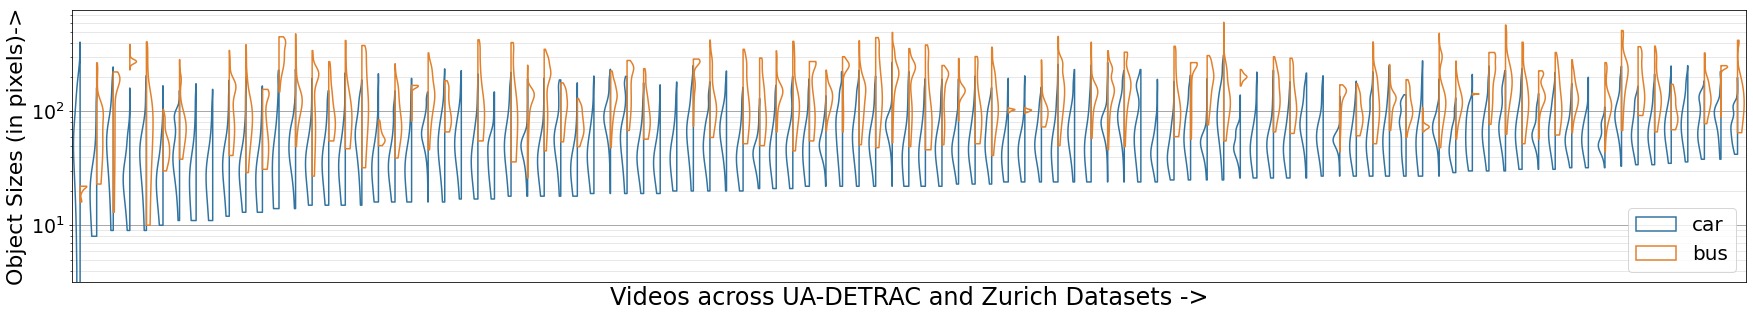

In [25]:
# Plot object size distribution in dataset

fig, ax = plt.subplots(figsize=(30,5))




ax = sns.violinplot(data=sorted_df, x="videos", y="Object Size (pixels)", hue="class",split=True,inner=None,cut=0,scale='count')

plotgridlines(ax)
#plt.xticks(rotation=90)
remove_xticks(ax)
ax.tick_params(axis='both', which='major', labelsize=19)
ax.tick_params(axis='both', which='minor', labelsize=19)
ax.legend(loc="lower right",fontsize=20)
ax.set_yscale('log')
ax.set_xlabel("Videos across UA-DETRAC and Zurich Datasets ->",fontsize=24)
ax.set_ylabel("Object Sizes (in pixels)->",fontsize=22)


# Style violins
for collection in ax.collections:
    if isinstance(collection, mpl.collections.PolyCollection):
        collection.set_edgecolor(collection.get_facecolor())
        facecolor = "none" #collection.get_facecolor() #'none'
        collection.set_facecolor(facecolor)
        #collection.set_alpha(0.5)
for h in ax.legend_.legendHandles:
    if isinstance(h, mpl.patches.Rectangle):
        #h.set_alpha(0.5)
        facecolor = "none" #h.get_facecolor() #'none'
        h.set_edgecolor(h.get_facecolor())
        h.set_facecolor(facecolor)
        h.set_linewidth(1.5)



PLOTS_DIR =  f"{PLOTS_ROOT_DIR}/"
plot_filename = f"{PLOTS_DIR}/ObjectSizeDistribution-{OBJECT_SIZE_DISTRIBUTION_SRC}_for_DATASET-{''.join(DATASET_LIST)}_CLASS-{''.join(selected_class_list)}"
fig.savefig(f"{plot_filename}.pdf", bbox_inches='tight')
fig.savefig(f"{plot_filename}.png", bbox_inches='tight')

In [26]:
# Helper functions to combine object size data with duration data

def getDataset(video_name):
    if video_name in dict_of_durations["ZurichDataset"].keys():
        return "ZurichDataset"
    
    if video_name in dict_of_durations["UA-DETRAC-Train"].keys():
        return "UA-DETRAC-Train"
    
    if video_name in dict_of_durations["UA-DETRAC-Test"].keys():
        return "UA-DETRAC-Test"
    
    return None

def getframeCount(row):
    video_file_name = row["video_file_name"]
    dataset = row["dataset"]
    
    return dict_of_durations[dataset][video_file_name]

def get_fps(dataset):
    if "Zurich" in dataset:
        return 30
    
    if "DETRAC" in dataset:
        return 25
    
    return None

def get_duration_of_video_in_secs(row):
    fps = row["fps"]
    noOfFrames = row["noOfFrames"]
    
    return noOfFrames/fps

In [27]:
# Get number of frames per video for videos in selected datasets 
dict_of_durations = {}

for dataset in DATASET_LIST:
    dict_of_durations[dataset] = {}
    if "Zurich" in dataset:
        VIDEO_ROOT_DIR = f"{DATASET_ROOT_DIR}/ZurichDataset/ZurichDroneDataset/DatasetVideo/"
    elif "UA-DETRAC-Train" in dataset:
        VIDEO_ROOT_DIR = f"{DATASET_ROOT_DIR}UA-DETRAC/DETRAC-train-data/TrainVideos/"
    elif "UA-DETRAC-Test" in dataset:
        VIDEO_ROOT_DIR = f"{DATASET_ROOT_DIR}UA-DETRAC/DETRAC-test-data/TestVideos/"
        
    list_of_video_file_names = sorted(filter(lambda x : (os.path.isfile(os.path.join(VIDEO_ROOT_DIR,x)) and (".mp4" in x) ),os.listdir(VIDEO_ROOT_DIR)))
    
    for video_file_name in list_of_video_file_names:
        video_path = f'"{VIDEO_ROOT_DIR}{video_file_name}"'
        cmd = f"ffprobe -v error -select_streams v:0 -count_packets -show_entries stream=nb_read_packets -of csv=p=0 {video_path}"
        result = subprocess.run(cmd, stdout=subprocess.PIPE,shell=True)
        size = int(result.stdout)
        #print(f"{dataset}-{video_file_name} : {size} frames")
        # Plot object size distribution in dataset

        dict_of_durations[dataset][video_file_name] = size


In [28]:
# Get a combined dataframe with object size and video duration
objeSizeSortedDf = sorted_df.copy(deep=True)
objeSizeSortedDf['video_file_name'] = objeSizeSortedDf["videos"].apply(lambda x: x.split("0_downsample_by_1.0")[1].split('results.txt')[0])
objeSizeSortedDf['dataset'] = objeSizeSortedDf["video_file_name"].apply(lambda x:getDataset(x))
objeSizeSortedDf['noOfFrames'] = objeSizeSortedDf.apply(lambda x: getframeCount(x),axis=1)
objeSizeSortedDf['fps'] = objeSizeSortedDf['dataset'].apply(lambda x: get_fps(x))
objeSizeSortedDf['duration_in_secs'] = objeSizeSortedDf.apply(lambda x:get_duration_of_video_in_secs(x),axis=1)
objeSizeSortedDf['duration_in_mins'] = objeSizeSortedDf['duration_in_secs']/60
objeSizeSortedDf

,videos,class,Object Size (pixels),dataset,noOfFrames,duration_in_secs,duration_in_mins,video_file_name,fps
0,0_downsample_by_1.0output.mp4results.txt,car,0.00,ZurichDataset,81169,2705.633333,45.093889,output.mp4,30
0,0_downsample_by_1.0MVI_39501.mp4results.txt,car,8.00,UA-DETRAC-Test,540,21.600000,0.360000,MVI_39501.mp4,25
0,0_downsample_by_1.0MVI_63521.mp4results.txt,car,9.00,UA-DETRAC-Train,2055,82.200000,1.370000,MVI_63521.mp4,25
0,0_downsample_by_1.0MVI_20063.mp4results.txt,car,9.00,UA-DETRAC-Train,800,32.000000,0.533333,MVI_20063.mp4,25
0,0_downsample_by_1.0MVI_40963.mp4results.txt,car,9.00,UA-DETRAC-Train,1820,72.800000,1.213333,MVI_40963.mp4,25
...,...,...,...,...,...,...,...,...,...
98,0_downsample_by_1.0MVI_40793.mp4results.txt,bus,527.34,UA-DETRAC-Test,1960,78.400000,1.306667,MVI_40793.mp4,25
99,0_downsample_by_1.0MVI_40181.mp4results.txt,bus,549.57,UA-DETRAC-Train,1700,68.000000,1.133333,MVI_40181.mp4,25
99,0_downsample_by_1.0MVI_40793.mp4results.txt,bus,552.35,UA-DETRAC-Test,1960,78.400000,1.306667,MVI_40793.mp4,25
100,0_downsample_by_1.0MVI_40793.mp4results.txt,bus,573.00,UA-DETRAC-Test,1960,78.400000,1.306667,MVI_40793.mp4,25


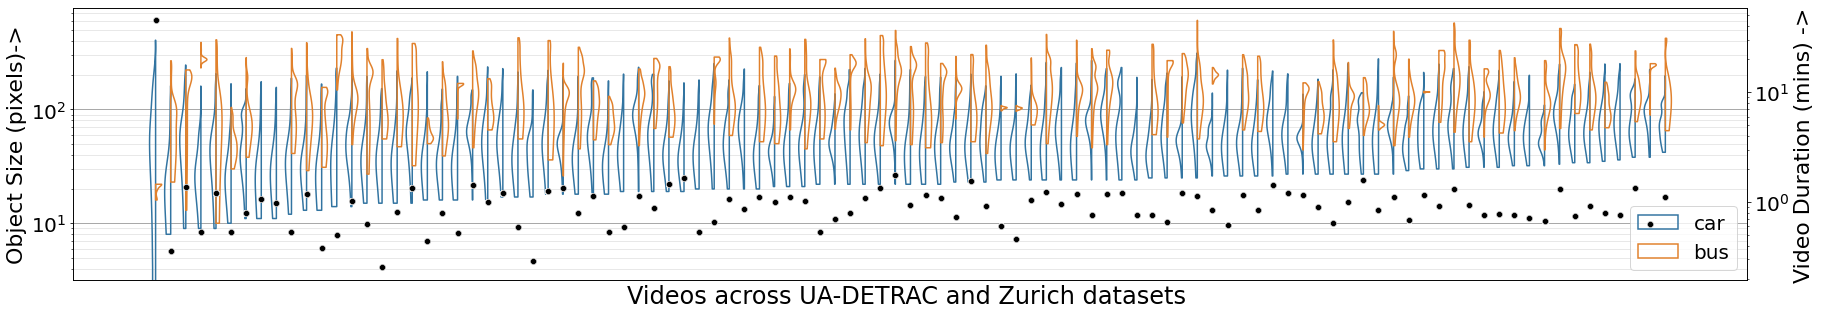

In [30]:
fig, ax = plt.subplots(figsize=(30,5))
ax2 = ax.twinx()  

ax = sns.violinplot(data=objeSizeSortedDf, x="video_file_name", y="Object Size (pixels)", hue="class",split=True,inner=None,cut=0,scale='count',ax=ax)
# plt.xticks(rotation=90)

ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='minor', labelsize=20)

ax.set_ylabel("Object Size (pixels)->",fontsize=22)
ax.set_xlabel("Videos across UA-DETRAC and Zurich datasets ",fontsize=24)

sns.scatterplot(data=objeSizeSortedDf, x="video_file_name", y="duration_in_mins",ax=ax2,color='black',legend='full')

plotgridlines(ax)
remove_xticks(ax)
remove_xticks(ax2)

ax.set_axisbelow(True)



ax.set_yscale('log')
ax.legend(loc="lower right",fontsize=20)
ax2.set_yscale('log')
ax2.set_ylabel("Video Duration (mins) ->",fontsize=22)

# Style violins
for collection in ax.collections:
    if isinstance(collection, mpl.collections.PolyCollection):
        collection.set_edgecolor(collection.get_facecolor())
        facecolor = "none" #collection.get_facecolor() #'none'
        collection.set_facecolor(facecolor)
        #collection.set_alpha(0.5)
for h in ax.legend_.legendHandles:
    if isinstance(h, mpl.patches.Rectangle):
        #h.set_alpha(0.5)
        facecolor = "none" #h.get_facecolor() #'none'
        h.set_edgecolor(h.get_facecolor())
        h.set_facecolor(facecolor)
        h.set_linewidth(1.5)


PLOTS_DIR =  f"{PLOTS_ROOT_DIR}/"
plot_filename = f"{PLOTS_DIR}/VideoDurationAndObjectSizeDistribution-{OBJECT_SIZE_DISTRIBUTION_SRC}_for_DATASET-{''.join(DATASET_LIST)}_CLASS-{''.join(selected_class_list)}"
fig.savefig(f"{plot_filename}.pdf", bbox_inches='tight')
fig.savefig(f"{plot_filename}.png", bbox_inches='tight')